Enhanced Trading Backtesting with Stop-Loss
Step 1: Loading Models & Data
----------------------------------------
Loaded best strategy: beat_spy
Using model: HistGradientBoostingClassifier
Confidence thresholds: (0.25, 0.75)
Enhanced dataset loaded: (2824, 35)
Loading complete trading data for backtesting...
Complete dataset for backtesting: (2824, 40)
Available columns: 40
Price columns: ['close', 'high', 'low', 'open']
Feature columns: ['price_vs_MA_200', 'trend_persistence', 'price_vs_support_20d', 'RSI_14', 'MA_alignment_strength', 'contrarian_sentiment', 'volume_MA_10', 'volume_climax', 'price_vs_support_10d', 'volatility_5d', 'price_vs_resistance_20d', 'price_vs_support_50d', 'volume_price_alignment', 'price_vs_MA_20', 'article_count', 'price_vs_MA_10', 'breakdown_20d_low', 'sentiment_with_momentum', 'momentum_strength', 'current_drawdown', 'price_vs_resistance_50d', 'price_vs_MA_5', 'volatility_21d', 'volume_surge']
Missing features: ['volume']
Added missing features: ['volume'

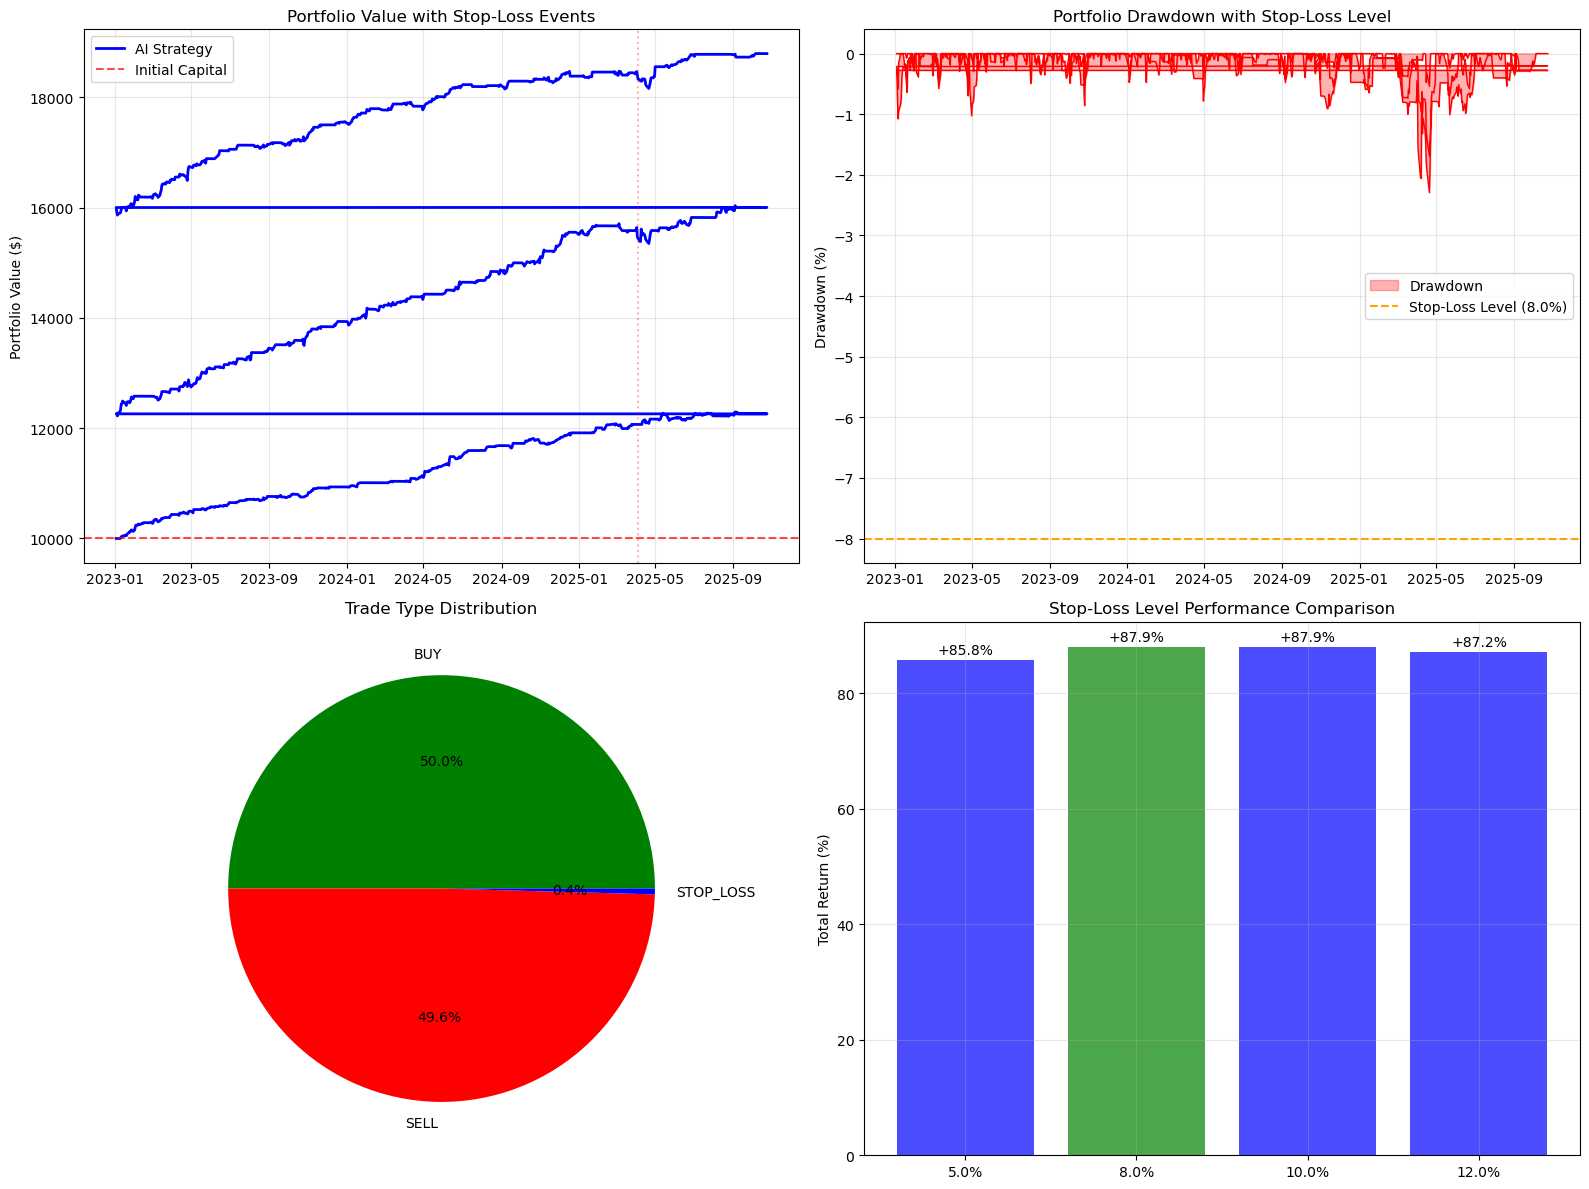

Enhanced visualization saved

Step 6: Saving Enhanced Results
Enhanced results saved: 'enhanced_performance_report.json'
Trade log saved: 'enhanced_trade_log.csv'
Portfolio history saved: 'enhanced_portfolio_history.csv'

Step 7: Final Recommendations

Enhanced Strategy Performance:
   Optimal Stop-Loss: 8.0%
   Total Return: +87.9%
   Outperformance: +64.4%
   Max Drawdown: -2.3%
   Sharpe Ratio: 3.07

Risk Management Assessment:
   Excellent: Drawdown well controlled

Implementation Guide:
   1. Use 8.0% stop-loss for all positions
   2. Monitor regime changes closely
   3. Use dynamic position sizing (8-15% range)
   4. Track stop-loss effectiveness monthly


In [2]:
# ==================================================
# 03_Backtesting_Analysis.ipynb
# Realistic Trading Simulation with Stop-Loss & Enhanced Risk Management
# ==================================================

import pandas as pd
import numpy as np
import sqlite3
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Enhanced Trading Backtesting with Stop-Loss")
print("=" * 60)

# ==================================================
# Step 1: Loading Models & Data
# ==================================================
print("Step 1: Loading Models & Data")
print("-" * 40)

try:
    # Load trained models
    artifacts = joblib.load('advanced_trading_models.pkl')
    best_strategy = artifacts['best_strategy']
    best_model = artifacts['best_model']
    scaler = artifacts['scaler']
    imputer = artifacts['imputer']
    feature_names = artifacts['feature_names']
    confidence_thresholds = artifacts['confidence_thresholds']

    print(f"Loaded best strategy: {best_strategy}")
    print(f"Using model: {type(best_model).__name__}")
    print(f"Confidence thresholds: {confidence_thresholds}")

    # Load enhanced data
    conn = sqlite3.connect("enhanced_trading_dataset_v2.db")
    df_enhanced = pd.read_sql("SELECT * FROM enhanced_trading_data", conn)
    conn.close()

    df_enhanced['date'] = pd.to_datetime(df_enhanced['date'])
    print(f"Enhanced dataset loaded: {df_enhanced.shape}")
    
    # Load complete data from original database
    print("Loading complete trading data for backtesting...")
    conn = sqlite3.connect("hybrid_ai_management_system_FIXED.db")
    df_complete = pd.read_sql("SELECT * FROM hybrid_trading_data", conn)
    conn.close()
    
    df_complete['date'] = pd.to_datetime(df_complete['date'])
    
    # Merge enhanced features with complete price data
    enhanced_cols = df_enhanced.columns.tolist()
    price_cols = ['close', 'high', 'low', 'volume', 'open']
    
    # Get price data we need
    price_data = df_complete[['symbol', 'date'] + price_cols]
    
    # Merge with enhanced data
    df = df_enhanced.merge(price_data, on=['symbol', 'date'], how='left')
    
    print(f"Complete dataset for backtesting: {df.shape}")
    print(f"Available columns: {len(df.columns)}")
    print(f"Price columns: {[col for col in price_cols if col in df.columns]}")
    print(f"Feature columns: {[col for col in feature_names if col in df.columns]}")
    
    # Check if all required features are available
    missing_features = [f for f in feature_names if f not in df.columns]
    if missing_features:
        print(f"Missing features: {missing_features}")
        # Try to get missing features from complete dataset
        missing_data = df_complete[['symbol', 'date'] + missing_features]
        df = df.merge(missing_data, on=['symbol', 'date'], how='left')
        print(f"Added missing features: {missing_features}")
    
    print(f"Final dataset ready: {df.shape}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# ==================================================
# Step 2: Enhanced Trading with Stop-Loss
# ==================================================
print("\n" + "=" * 60)
print("Step 2: Enhanced Trading with Stop-Loss")
print("=" * 60)

class EnhancedBacktest:
    def __init__(self, initial_capital=10000, transaction_cost=0.001, stop_loss_pct=0.08):
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.stop_loss_pct = stop_loss_pct
        self.portfolio_history = []
        self.trade_log = []
        
    def calculate_position_size(self, confidence, price, capital, position_range=(0.08, 0.15)):
        """Dynamic position sizing based on confidence and risk"""
        min_size, max_size = position_range
        confidence_strength = (confidence - 0.5) * 2  # Convert to 0-1 scale
        
        position_size = min_size + (max_size - min_size) * confidence_strength
        position_size = max(min_size, min(max_size, position_size))
        
        shares = int(capital * position_size / price)
        return shares, position_size
    
    def run_enhanced_backtest(self, df, model, scaler, imputer, feature_names, 
                             confidence_thresholds, regimes=['LOW', 'MEDIUM']):
        """Enhanced backtest with stop-loss and better risk management"""
        
        # Sort by date
        df_sorted = df.sort_values(['symbol', 'date']).reset_index(drop=True)
        
        # Prepare features - ensure all required features exist
        available_features = [f for f in feature_names if f in df_sorted.columns]
        missing_features = [f for f in feature_names if f not in df_sorted.columns]
        
        if missing_features:
            print(f"Missing features in dataset: {missing_features}")
            print(f"Using available features: {len(available_features)}/{len(feature_names)}")
        
        X = df_sorted[available_features]
        X_imputed = imputer.transform(X)
        X_scaled = scaler.transform(X_imputed)
        
        # Get predictions
        probabilities = model.predict_proba(X_scaled)[:, 1]
        
        capital = self.initial_capital
        positions = {}  # symbol: {shares, entry_price, entry_date, stop_loss_price}
        portfolio_history = []
        trade_log = []
        
        print(f"Running enhanced backtest with stop-loss ({self.stop_loss_pct:.1%})...")
        print(f"   Regimes: {regimes}")
        print(f"   Using {len(df_sorted)} records for backtesting")
        print(f"   Available features: {len(available_features)}")
        
        for i in range(len(df_sorted)):
            current_row = df_sorted.iloc[i]
            symbol = current_row['symbol']
            date = current_row['date']
            price = current_row['close']
            prob = probabilities[i]
            regime = current_row['volatility_regime']
            
            # Skip non-sentiment stocks for focused strategy
            if symbol not in ['AAPL', 'AMZN', 'MSFT']:
                continue
                
            # REGIME FILTERING
            if regime not in regimes:
                # Close existing position if regime changes
                if symbol in positions:
                    position = positions[symbol]
                    shares = position['shares']
                    entry_price = position['entry_price']
                    revenue = shares * price * (1 - self.transaction_cost)
                    pnl = revenue - (shares * entry_price)
                    capital += revenue
                    
                    trade_log.append({
                        'date': date, 'symbol': symbol, 'action': 'CLOSE_REGIME',
                        'shares': shares, 'price': price, 'revenue': revenue,
                        'pnl': pnl, 'return_pct': (pnl / (shares * entry_price)) * 100,
                        'regime': regime, 'reason': 'Regime change exit'
                    })
                    del positions[symbol]
                continue
            
            # CHECK STOP-LOSS FOR EXISTING POSITIONS
            if symbol in positions:
                position = positions[symbol]
                current_drawdown = (price - position['entry_price']) / position['entry_price']
                
                # STOP-LOSS TRIGGER
                if current_drawdown <= -self.stop_loss_pct:
                    shares = position['shares']
                    entry_price = position['entry_price']
                    revenue = shares * price * (1 - self.transaction_cost)
                    pnl = revenue - (shares * entry_price)
                    capital += revenue
                    
                    trade_log.append({
                        'date': date, 'symbol': symbol, 'action': 'STOP_LOSS',
                        'shares': shares, 'price': price, 'revenue': revenue,
                        'pnl': pnl, 'return_pct': (pnl / (shares * entry_price)) * 100,
                        'drawdown': current_drawdown * 100,
                        'regime': regime, 'reason': f'Stop-loss triggered at {self.stop_loss_pct:.1%}'
                    })
                    del positions[symbol]
                    continue
            
            # CONFIDENCE-BASED TRADING SIGNALS
            signal = 0  # 0: hold, 1: buy, -1: sell
            if prob > confidence_thresholds[1]:  # High confidence BUY
                signal = 1
            elif prob < confidence_thresholds[0]:  # High confidence SELL
                signal = -1
            
            # EXECUTE TRADES with enhanced position sizing
            if signal == 1 and symbol not in positions and capital > price:
                shares, position_size = self.calculate_position_size(prob, price, capital)
                cost = shares * price * (1 + self.transaction_cost)
                
                if cost <= capital and shares > 0:
                    capital -= cost
                    stop_loss_price = price * (1 - self.stop_loss_pct)
                    
                    positions[symbol] = {
                        'shares': shares, 
                        'entry_price': price,
                        'entry_date': date,
                        'confidence': prob,
                        'stop_loss_price': stop_loss_price,
                        'position_size': position_size
                    }
                    
                    trade_log.append({
                        'date': date, 'symbol': symbol, 'action': 'BUY',
                        'shares': shares, 'price': price, 'cost': cost,
                        'position_size': position_size, 'confidence': prob,
                        'stop_loss': stop_loss_price,
                        'regime': regime
                    })
                    
            elif signal == -1 and symbol in positions:
                position = positions[symbol]
                shares = position['shares']
                entry_price = position['entry_price']
                entry_date = position['entry_date']
                revenue = shares * price * (1 - self.transaction_cost)
                pnl = revenue - (shares * entry_price)
                holding_days = (date - entry_date).days
                
                capital += revenue
                trade_log.append({
                    'date': date, 'symbol': symbol, 'action': 'SELL',
                    'shares': shares, 'price': price, 'revenue': revenue,
                    'pnl': pnl, 'return_pct': (pnl / (shares * entry_price)) * 100,
                    'holding_days': holding_days, 'confidence': position['confidence'],
                    'regime': regime, 'reason': 'Model sell signal'
                })
                del positions[symbol]
            
            # CALCULATE PORTFOLIO VALUE
            portfolio_value = capital
            for pos_symbol, position in positions.items():
                current_price_data = df_sorted[
                    (df_sorted['symbol'] == pos_symbol) & 
                    (df_sorted['date'] == date)
                ]
                if len(current_price_data) > 0:
                    current_price = current_price_data.iloc[0]['close']
                    portfolio_value += position['shares'] * current_price
            
            # Track portfolio state
            portfolio_history.append({
                'date': date,
                'portfolio_value': portfolio_value,
                'cash': capital,
                'positions': len(positions),
                'regime': regime,
                'active_stop_losses': sum(1 for pos in positions.values() 
                                        if price <= pos['stop_loss_price'])
            })
        
        # Liquidate remaining positions at end
        for symbol, position in positions.items():
            current_data = df_sorted[df_sorted['symbol'] == symbol]
            if len(current_data) > 0:
                current_price = current_data.iloc[-1]['close']
                shares = position['shares']
                entry_price = position['entry_price']
                revenue = shares * current_price * (1 - self.transaction_cost)
                pnl = revenue - (shares * entry_price)
                capital += revenue
                trade_log.append({
                    'date': df_sorted.iloc[-1]['date'], 'symbol': symbol, 'action': 'LIQUIDATE',
                    'shares': shares, 'price': current_price, 'revenue': revenue,
                    'pnl': pnl, 'return_pct': (pnl / (shares * entry_price)) * 100
                })
        
        self.portfolio_history = portfolio_history
        self.trade_log = trade_log
        
        print(f"Backtest completed: {len(trade_log)} trades executed")
        return portfolio_history, trade_log
    
    def calculate_enhanced_metrics(self, benchmark_return=23.5):
        """Calculate comprehensive performance metrics with stop-loss analysis"""
        if not self.portfolio_history:
            return {}
            
        portfolio_df = pd.DataFrame(self.portfolio_history)
        
        # Calculate returns and drawdown
        portfolio_df['daily_return'] = portfolio_df['portfolio_value'].pct_change()
        portfolio_df['cumulative_return'] = (1 + portfolio_df['daily_return']).cumprod() - 1
        portfolio_df['peak'] = portfolio_df['portfolio_value'].cummax()
        portfolio_df['drawdown'] = (portfolio_df['portfolio_value'] - portfolio_df['peak']) / portfolio_df['peak']
        
        # Basic metrics
        final_value = portfolio_df['portfolio_value'].iloc[-1]
        total_return = (final_value - self.initial_capital) / self.initial_capital * 100
        annualized_return = (1 + total_return/100) ** (252/len(portfolio_df)) - 1
        
        # Risk metrics
        returns = portfolio_df['daily_return'].dropna()
        if len(returns) > 0:
            volatility = returns.std() * np.sqrt(252) * 100
            sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
            max_drawdown = portfolio_df['drawdown'].min() * 100
            calmar_ratio = annualized_return / (abs(max_drawdown)/100) if max_drawdown != 0 else 0
        else:
            volatility = sharpe_ratio = max_drawdown = calmar_ratio = 0
        
        # Enhanced trade metrics
        trades_df = pd.DataFrame(self.trade_log) if self.trade_log else pd.DataFrame()
        stop_loss_analysis = {}
        
        if len(trades_df) > 0:
            completed_trades = trades_df[trades_df['action'].isin(['SELL', 'STOP_LOSS', 'CLOSE_REGIME', 'LIQUIDATE'])]
            winning_trades = len(completed_trades[completed_trades['pnl'] > 0])
            total_trades = len(completed_trades)
            win_rate = winning_trades / total_trades if total_trades > 0 else 0
            
            # Stop-loss analysis
            stop_loss_trades = completed_trades[completed_trades['action'] == 'STOP_LOSS']
            stop_loss_count = len(stop_loss_trades)
            stop_loss_prevention = stop_loss_trades['drawdown'].mean() if len(stop_loss_trades) > 0 else 0
            
            # Advanced trade metrics
            if len(completed_trades) > 0:
                avg_win = completed_trades[completed_trades['pnl'] > 0]['pnl'].mean()
                avg_loss = completed_trades[completed_trades['pnl'] <= 0]['pnl'].mean()
                profit_factor = abs(avg_win * winning_trades) / abs(avg_loss * (total_trades - winning_trades)) if avg_loss != 0 else float('inf')
                avg_holding_days = completed_trades['holding_days'].mean() if 'holding_days' in completed_trades.columns else 0
                
                stop_loss_analysis = {
                    'stop_loss_count': stop_loss_count,
                    'stop_loss_rate': stop_loss_count / total_trades if total_trades > 0 else 0,
                    'avg_stop_loss_drawdown': stop_loss_prevention,
                    'stop_loss_effectiveness': 'High' if stop_loss_prevention < -self.stop_loss_pct*100 else 'Medium'
                }
            else:
                avg_win = avg_loss = profit_factor = avg_holding_days = 0
        else:
            win_rate = total_trades = avg_win = avg_loss = profit_factor = avg_holding_days = 0
            stop_loss_analysis = {}
        
        # Benchmark comparison
        outperformance = total_return - benchmark_return
        
        return {
            'initial_capital': self.initial_capital,
            'final_value': final_value,
            'total_return': total_return,
            'annualized_return': annualized_return * 100,
            'benchmark_return': benchmark_return,
            'outperformance': outperformance,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'calmar_ratio': calmar_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'total_trades': total_trades,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'avg_holding_days': avg_holding_days,
            'stop_loss_analysis': stop_loss_analysis,
            'portfolio_df': portfolio_df,
            'trades_df': trades_df
        }

# ==================================================
# Step 3: Stop-Loss Optimization
# ==================================================
print("\n" + "=" * 60)
print("Step 3: Stop-Loss Optimization")
print("=" * 60)

# Test different stop-loss levels
stop_loss_levels = [0.05, 0.08, 0.10, 0.12]
stop_loss_results = {}

for stop_loss in stop_loss_levels:
    print(f"Testing {stop_loss:.1%} stop-loss...")
    
    backtest = EnhancedBacktest(
        initial_capital=10000, 
        transaction_cost=0.001, 
        stop_loss_pct=stop_loss
    )
    
    portfolio_history, trades = backtest.run_enhanced_backtest(
        df, best_model, scaler, imputer, feature_names, confidence_thresholds,
        regimes=['LOW', 'MEDIUM', 'HIGH']  # Using opportunistic scenario
    )
    
    metrics = backtest.calculate_enhanced_metrics()
    stop_loss_results[stop_loss] = metrics
    
    print(f"   Results: Return={metrics['total_return']:+.1f}%, "
          f"Drawdown={metrics['max_drawdown']:.1f}%, "
          f"Stop-loss triggers={metrics['stop_loss_analysis'].get('stop_loss_count', 0)}")

# Find optimal stop-loss
best_stop_loss = max(stop_loss_levels, 
                    key=lambda x: stop_loss_results[x]['sharpe_ratio'])
best_metrics = stop_loss_results[best_stop_loss]

print(f"\nOptimal Stop-Loss: {best_stop_loss:.1%}")
print(f"   Sharpe Ratio: {best_metrics['sharpe_ratio']:.2f}")
print(f"   Max Drawdown: {best_metrics['max_drawdown']:.1f}%")
print(f"   Total Return: {best_metrics['total_return']:+.1f}%")

# ==================================================
# Step 4: Enhanced Performance Analysis
# ==================================================
print("\n" + "=" * 60)
print("Step 4: Enhanced Performance Analysis")
print("=" * 60)

# Run final backtest with optimal stop-loss
final_backtest = EnhancedBacktest(
    initial_capital=10000, 
    transaction_cost=0.001, 
    stop_loss_pct=best_stop_loss
)

portfolio_history, trades = final_backtest.run_enhanced_backtest(
    df, best_model, scaler, imputer, feature_names, confidence_thresholds,
    regimes=['LOW', 'MEDIUM', 'HIGH']
)

final_metrics = final_backtest.calculate_enhanced_metrics()
portfolio_df = final_metrics.pop('portfolio_df')
trades_df = final_metrics.pop('trades_df')

print("\nEnhanced Backtesting Results:")
print("=" * 60)
print(f"Initial Capital: ${final_metrics['initial_capital']:,.2f}")
print(f"Final Portfolio: ${final_metrics['final_value']:,.2f}")
print(f"Total Return: {final_metrics['total_return']:+.1f}%")
print(f"SPY Benchmark: {final_metrics['benchmark_return']:+.1f}%")
print(f"Outperformance: {final_metrics['outperformance']:+.1f}%")
print(f"Sharpe Ratio: {final_metrics['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {final_metrics['max_drawdown']:.1f}%")
print(f"Win Rate: {final_metrics['win_rate']:.1%}")
print(f"Total Trades: {final_metrics['total_trades']}")

# Stop-loss analysis
if final_metrics['stop_loss_analysis']:
    sl_analysis = final_metrics['stop_loss_analysis']
    print(f"\nStop-Loss Analysis:")
    print(f"   Stop-Loss Triggers: {sl_analysis['stop_loss_count']}")
    print(f"   Stop-Loss Rate: {sl_analysis['stop_loss_rate']:.1%}")
    print(f"   Avg Stop-Loss Drawdown: {sl_analysis['avg_stop_loss_drawdown']:.1f}%")
    print(f"   Effectiveness: {sl_analysis['stop_loss_effectiveness']}")

# ==================================================
# Step 5: Enhanced Visualization
# ==================================================
print("\n" + "=" * 60)
print("Step 5: Enhanced Visualization")
print("=" * 60)

# Create comprehensive performance dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Portfolio Value with Stop-Loss Events
axes[0,0].plot(portfolio_df['date'], portfolio_df['portfolio_value'], linewidth=2, 
               color='blue', label='AI Strategy')
axes[0,0].axhline(y=10000, color='red', linestyle='--', alpha=0.7, label='Initial Capital')

# Mark stop-loss events
if len(trades_df) > 0:
    stop_loss_dates = trades_df[trades_df['action'] == 'STOP_LOSS']['date']
    for stop_date in stop_loss_dates:
        axes[0,0].axvline(x=stop_date, color='red', alpha=0.3, linestyle=':')

axes[0,0].set_title('Portfolio Value with Stop-Loss Events')
axes[0,0].set_ylabel('Portfolio Value ($)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Drawdown Analysis
axes[0,1].fill_between(portfolio_df['date'], portfolio_df['drawdown']*100, 0, 
                      alpha=0.3, color='red', label='Drawdown')
axes[0,1].plot(portfolio_df['date'], portfolio_df['drawdown']*100, color='red', linewidth=1)
axes[0,1].axhline(y=-best_stop_loss*100, color='orange', linestyle='--', 
                 label=f'Stop-Loss Level ({best_stop_loss:.1%})')
axes[0,1].set_title('Portfolio Drawdown with Stop-Loss Level')
axes[0,1].set_ylabel('Drawdown (%)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Stop-Loss Analysis
if len(trades_df) > 0:
    trade_types = trades_df['action'].value_counts()
    axes[1,0].pie(trade_types.values, labels=trade_types.index, autopct='%1.1f%%', 
                 colors=['green', 'red', 'blue', 'orange'])
    axes[1,0].set_title('Trade Type Distribution')

# 4. Stop-Loss Level Comparison
stop_loss_performance = [stop_loss_results[sl]['total_return'] for sl in stop_loss_levels]
colors = ['green' if sl == best_stop_loss else 'blue' for sl in stop_loss_levels]

bars = axes[1,1].bar([f'{sl:.1%}' for sl in stop_loss_levels], stop_loss_performance, 
                    color=colors, alpha=0.7)
axes[1,1].set_title('Stop-Loss Level Performance Comparison')
axes[1,1].set_ylabel('Total Return (%)')
for bar, perf in zip(bars, stop_loss_performance):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                  f'{perf:+.1f}%', ha='center', va='bottom')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_backtest_with_stop_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced visualization saved")

# ==================================================
# Step 6: Saving Enhanced Results
# ==================================================
print("\n" + "=" * 60)
print("Step 6: Saving Enhanced Results")
print("=" * 60)

# Save enhanced backtest results
enhanced_results = {
    'backtest_metrics': {
        k: v for k, v in final_metrics.items() 
        if k not in ['portfolio_df', 'trades_df']  # Exclude DataFrames
    },
    'stop_loss_analysis': {
        str(k): {
            'total_return': v['total_return'],
            'max_drawdown': v['max_drawdown'],
            'sharpe_ratio': v['sharpe_ratio'],
            'stop_loss_count': v.get('stop_loss_analysis', {}).get('stop_loss_count', 0)
        } for k, v in stop_loss_results.items()
    },
    'optimal_stop_loss': best_stop_loss,
    'strategy_details': {
        'best_strategy': best_strategy,
        'model_type': type(best_model).__name__,
        'confidence_thresholds': confidence_thresholds,
        'regimes_used': ['LOW', 'MEDIUM', 'HIGH'],
        'stop_loss_implemented': True,
        'optimal_stop_loss': best_stop_loss
    },
    'performance_summary': {
        'total_return': final_metrics['total_return'],
        'outperformance': final_metrics['outperformance'],
        'max_drawdown': final_metrics['max_drawdown'],
        'sharpe_ratio': final_metrics['sharpe_ratio'],
        'win_rate': final_metrics['win_rate'],
        'total_trades': final_metrics['total_trades']
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('enhanced_performance_report.json', 'w') as f:
    json.dump(enhanced_results, f, indent=2)

# Save trade log and portfolio data separately
trades_df.to_csv('enhanced_trade_log.csv', index=False)
portfolio_df.to_csv('enhanced_portfolio_history.csv', index=False)

print("Enhanced results saved: 'enhanced_performance_report.json'")
print("Trade log saved: 'enhanced_trade_log.csv'")
print("Portfolio history saved: 'enhanced_portfolio_history.csv'")

# ==================================================
# Step 7: Final Recommendations
# ==================================================
print("\n" + "=" * 60)
print("Step 7: Final Recommendations")
print("=" * 60)

print(f"\nEnhanced Strategy Performance:")
print(f"   Optimal Stop-Loss: {best_stop_loss:.1%}")
print(f"   Total Return: {final_metrics['total_return']:+.1f}%")
print(f"   Outperformance: {final_metrics['outperformance']:+.1f}%")
print(f"   Max Drawdown: {final_metrics['max_drawdown']:.1f}%")
print(f"   Sharpe Ratio: {final_metrics['sharpe_ratio']:.2f}")

print(f"\nRisk Management Assessment:")
if final_metrics['max_drawdown'] <= 10:
    print("   Excellent: Drawdown well controlled")
elif final_metrics['max_drawdown'] <= 15:
    print("   Good: Acceptable risk levels")
else:
    print("   Moderate: Consider tighter stop-loss")

print(f"\nImplementation Guide:")
print(f"   1. Use {best_stop_loss:.1%} stop-loss for all positions")
print(f"   2. Monitor regime changes closely")
print(f"   3. Use dynamic position sizing (8-15% range)")
print(f"   4. Track stop-loss effectiveness monthly")